In [51]:
import os
import matplotlib
import warnings

import pandas               as pd
import numpy                as np
import matplotlib.pyplot    as plt
import seaborn              as sns
from sklearn.cluster        import KMeans, DBSCAN
from sklearn.preprocessing  import StandardScaler, MinMaxScaler, Normalizer, RobustScaler

warnings.filterwarnings('ignore')

plt.style.use('ggplot')

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['figure.figsize'] = [16,6]


In [52]:
datasets_path = "../datasets/"

datasets_names =  os.listdir(datasets_path)

print("O nosso banco de dados é constituído pelos seguintes datasets:\n")
for i,x in enumerate(datasets_names):
    print(f"{i+1}: {x.split('.')[0]}")

O nosso banco de dados é constituído pelos seguintes datasets:

1: Future Bookings (All Clients)0
2: Receipt Transactions0
3: Product Listing (Retail)0
4: hair_salon_no_show_wrangled_df
5: Client Cancellations0
6: No-Show Report0
7: Service Listing0


Vamos discorrer acerca de cada um dos datasets, a descrição a seguir foi disponibilizada pelo criador dessa base:

>* **Future Bookings (All Clients)**
>    * Reservas futuras é o conjunto de todas as reservas não canceladas. O conjunto de todas as reservas é a união dos Cancelamentos de Clientes e Reservas Futuras

>* **Receipt Transactions**
>    * Esta é uma lista de todas as transações com recibos. Eu uso isso para determinar 1) se a receita foi gerada para cada reserva e 2) se um produto foi comprado. A geração de receita é usada como parte da lógica de não comparecimento.

>* **Product Listing (Retail)**
>    * Esta é uma lista de todos os produtos de varejo. Não usei esses dados para análise e eles não estão incorporados no dataframe hair_salon_no_show_wrangled_df.

>* **hair_salon_no_show_wrangled_df**
>    * É um único dataframe que organiza todos os campos necessários de todos os outros arquivos em preparação para análise. Em particular, projetei alguns recursos adicionais, como a última reserva dos clientes (antes da data de reserva atual), bem como alguns totais cumulativos de séries temporais.

>* **Client Cancellations**
>    * Cancelamentos de clientes são reservas que foram canceladas. O conjunto de todas as reservas é a união dos Cancelamentos de Clientes e Reservas Futuras.

>* **No-Show Report0**
>    * Esta é uma lista de reservas de não comparecimento que não foram canceladas antes da data da reserva. Este conjunto não inclui cancelamentos fora da política, portanto, para fins de análise, recriei os não comparecimentos no dataframe disputado.

>* **Service Listing0**
>    * Esta é uma lista de todos os serviços. Esta informação é necessária para juntar reservas com recibos.



Carregando todos os datasets, exceto o hair_salon_no_show_wrangled

In [53]:
reservas_futuras = pd.read_csv(datasets_path+datasets_names[0])
transacoes = pd.read_csv(datasets_path+datasets_names[1])
produtos = pd.read_csv(datasets_path+datasets_names[2])
cancelados = pd.read_csv(datasets_path+datasets_names[4])
faltantes = pd.read_csv(datasets_path+datasets_names[5])
servicos = pd.read_csv(datasets_path+datasets_names[6])

dataframes ={'reservas_futuras':reservas_futuras,
             'transacoes':transacoes,
             'produtos':produtos,
             'cancelados':cancelados,
             'faltantes':faltantes,
             'servicos':servicos}

Vamos verificar cada dataset para termos uma ideia de como estão constituídos

In [54]:
def separador():
    print("-"*200)

print('Reservas futuras: São as reservas que não foram canceladas')
display(reservas_futuras.head())

separador()
print('\nTransacoes: Todas as transações efetuadas')
display(transacoes.head())

separador()
print('\nProdutos: Todos os produtos utilizados')
display(produtos.head())

separador()
print('\nCancelados: Os clientes que cancelaram suas reservas')
display(cancelados.head())

separador()
print("\nFaltantes: Lista da reserva não honrada, isto é, as pessoas reservaram mas não compareceram")
display(faltantes.head())

separador()
print("\nServicos: Lista de serviços disponíveis")
display(servicos.head())

Reservas futuras: São as reservas que não foram canceladas


,Code,Staff,Service,Date,Time,TimeInt
0,JUNJ01,JJ,CON,03/14/2018,3:50:00 PM,950
1,NORJ01,JJ,SHCM,03/14/2018,4:00:00 PM,960
2,CORS01,JJ,SHCW,03/15/2018,2:10:00 PM,850
3,KERT01,JJ,SHCW,03/15/2018,10:00:00 AM,600
4,LEHJ01,JJ,SHCM,03/15/2018,6:00:00 PM,1080


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Transacoes: Todas as transações efetuadas


,Receipt,Date,Description,Client,Staff,Quantity,Amount,GST,PST
0,10,03/15/2018,Women's hair cut,KERT01,JJ,1,82.0,4.10,6.56
1,100,04/05/2018,Women's hair cut,COOM01,SINEAD,1,70.0,3.50,5.60
2,1000,06/09/2018,Consultation,PEDM01,JJ,1,0.0,0.00,0.00
3,1001,06/09/2018,Women's hair cut,BAIS01,KELLY,1,55.0,2.75,4.40
4,1003,06/09/2018,Women's hair cut,FRAL01,KELLY,1,65.0,3.25,5.20


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Produtos: Todos os produtos utilizados


,IsActive,Code,Description,Supplier,Brand,Category,Price,On Hand,Minimum,Maximum,Cost,COG,YTD,Package
0,True,AGBALANCE335M,AG balance 355ml,VENUS,AG,RETAIL,30.0,2,2,2,0.0,0.0,27.0,False
1,True,AGBOOST355ML,AG Boost 355ml,VENUS,AG,RETAIL,30.0,3,2,2,18.0,54.0,0.0,False
2,True,AGCLOUD107ML,AG Cloud 107ml,VENUS,AG,RETAIL,26.0,4,2,2,15.6,62.4,23.4,False
3,True,AGDRYLIFT44ML,AG Dry Lift 44ml,VENUS,AG,RETAIL,24.0,1,2,2,14.4,14.4,43.2,False
4,True,AGREMEDY148ML,AG Remedy 148ml,VENUS,AG,RETAIL,26.0,3,2,2,15.6,46.8,0.0,False


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Cancelados: Os clientes que cancelaram suas reservas


,Cancel Date,Code,Service,Staff,Booking Date,Canceled By,Days
0,05/22/2018,MASA01,CFC,JOANNE,05/24/2018,ADMIN,2.0
1,06/27/2018,MASA01,CBAL,KELLY,06/27/2018,ADMIN,0.0
2,07/03/2018,MASA01,SHCM,BECKY,07/10/2018,BECKY,7.0
3,07/10/2018,MASA01,SHCC,JJ,07/11/2018,KELLY,1.0
4,07/24/2018,TRUA01,SHCM,KELLY,07/24/2018,TANYA,0.0


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Faltantes: Lista da reserva não honrada, isto é, as pessoas reservaram mas não compareceram


,Date,Code,Service,Staff
0,04/13/2018,NaN,SHCW,JJ
1,07/27/2018,AMAB01,SHCM,KELLY
2,06/07/2018,APPS01,SBD,KELLY
3,06/05/2018,ASIS01,SHCW,KELLY
4,05/31/2018,BISD01,CON,SINEAD


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Servicos: Lista de serviços disponíveis


,IsActive,Code,Desc,Cate,Price,Cost
0,True,CAL,accent lights,COLOR,0,10
1,True,CALC,Accent lights and color,COLOR,0,10
2,True,CAS,Color additional service,COLOR,0,10
3,True,CBAL,Balayage,COLOR,0,10
4,True,CCAMO,Men's camo color,COLOR,45,5


Vamos brevemente observar se há valores faltantes e duplicados em cada dataset carregado

In [55]:
for key,value in dataframes.items():
    print(f"-----------------------dataset: {key}---------------------------------")
    print(f"Total de faltantes: {value.isna().sum().sum()}")
    print(f"Total de duplicados: {value.duplicated().sum()}\n")

-----------------------dataset: reservas_futuras---------------------------------
Total de faltantes: 1
Total de duplicados: 0

-----------------------dataset: transacoes---------------------------------
Total de faltantes: 3
Total de duplicados: 1

-----------------------dataset: produtos---------------------------------
Total de faltantes: 9
Total de duplicados: 0

-----------------------dataset: cancelados---------------------------------
Total de faltantes: 2
Total de duplicados: 2

-----------------------dataset: faltantes---------------------------------
Total de faltantes: 1
Total de duplicados: 0

-----------------------dataset: servicos---------------------------------
Total de faltantes: 1
Total de duplicados: 0



Vamos remover os valores duplicados. Com relação aos valores nulos podemos lidar depois

In [56]:
transacoes = transacoes.drop_duplicates()
cancelados = cancelados.drop_duplicates()

dataframes ={'reservas_futuras':reservas_futuras,
             'transacoes':transacoes,
             'produtos':produtos,
             'cancelados':cancelados,
             'faltantes':faltantes,
             'servicos':servicos}

----
## **Salão e funcionários**


Vamos iniciar as análises conhecendo melhor sobre o salão e os seus funcionários.

Utilizaremos os seguintes datasets:

>* Serviços 
>   * utilizado para entender quais serviços estão sendo oferecidos

>* Transações 
>   * utilizado para entender os funcionários do salão

Vamos iniciar observando quem são as pessoas que trabalham nesse salão

In [57]:
# Apenas uma correção no tipo da data de object para datetime
transacoes['Date'] = pd.to_datetime(transacoes['Date'])

Ao todo o salão tem 7 funcionários cujos nomes estão listados na tabela logo abaixo

In [58]:
pd.DataFrame(transacoes['Staff'].unique(),columns=['Funcionários'])

,Funcionários
0,JJ
1,SINEAD
2,KELLY
3,JOANNE
4,BECKY
5,HOUSE
6,TANYA


Observamos que o JJ é o empregado mais antigo, enquanto a Tanya a mais nova. Entretanto, a diferença entre as datas de ambos é de apenas 4 meses, portanto, ambos são recentes nesse emprego.

In [59]:
transacoes.groupby('Staff')['Date'].min().sort_values(ascending=False).to_frame()

,Date
Staff,
TANYA,2018-07-11
JOANNE,2018-05-04
KELLY,2018-04-04
BECKY,2018-04-03
SINEAD,2018-04-03
HOUSE,2018-04-01
JJ,2018-03-15


Agora vamos analisar o quanto cada funcionário gera de receita, vamos particionar essa tarefa em duas partes.

1. Global: Vamos considerar todos os serviços prestado pelos funcionário e calcular a média e a soma total dos faturamentos

2. Mensal: Vamos também calcular a média e a soma total dos faturamentos, mas dessa vez mensalmente

### Parte 1: Global

Observamos que a nossa base tem informações apenas de 4 meses de serviços. 

In [60]:
print(f"Menor data: {transacoes['Date'].min()}\nMaior data: {transacoes['Date'].max()}\nDiferença: {(transacoes['Date'].max() - transacoes['Date'].min())} -> equivalente a 4 meses")

Menor data: 2018-03-15 00:00:00
Maior data: 2018-07-29 00:00:00
Diferença: 136 days 00:00:00 -> equivalente a 4 meses


Vamos calcular a receita total, receita média por atendimento, desvio padrão das receitas e fazer alguns gráficos

In [61]:
receita = transacoes.groupby(['Staff'])['Amount'].agg(['mean','sum','std']).sort_values(by='sum',ascending=False)
#receita = receita.reset_index()
receita['Staff'] = receita.index
receita['percent_sum'] = receita['sum']/(receita['sum'].sum()) *100
receita['percent_mean'] = receita['mean']/(receita['mean'].sum())*100
receita

,mean,sum,std,Staff,percent_sum,percent_mean
Staff,,,,,,
JJ,65.171403,46467.21,29.460194,JJ,40.132659,18.304792
JOANNE,93.912379,21318.11,47.360826,JOANNE,18.411961,26.377314
BECKY,51.208259,20585.72,25.961989,BECKY,17.779412,14.382942
KELLY,52.930473,15667.42,30.627268,KELLY,13.531590,14.866663
SINEAD,55.527807,10383.70,23.535559,SINEAD,8.968163,15.596181
HOUSE,10.498617,986.87,113.204572,HOUSE,0.852337,2.948763
TANYA,26.785714,375.00,11.369179,TANYA,0.323879,7.523345


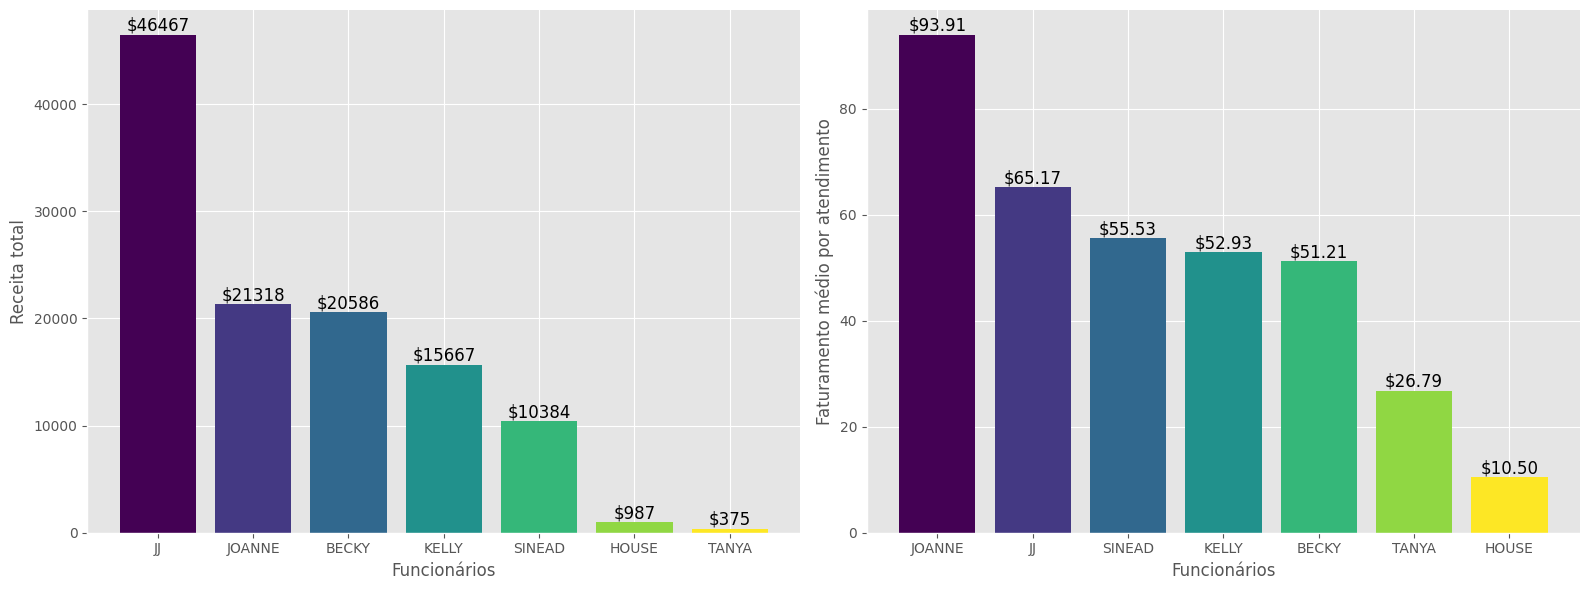

In [62]:
fig, ax = plt.subplots(1,2,figsize=(16,6))


paleta_cores = plt.cm.viridis(np.linspace(0, 1, len(receita)))
ax[0].bar(x=receita['Staff'], height=receita['sum'],color=paleta_cores)

receita = receita.sort_values(by='mean',ascending=False)
ax[1].bar(x=receita['Staff'], height=receita['mean'],color=paleta_cores)

for i in range(2):
    for staff in receita['Staff']:
        
        if i == 0:
            ax[0].text(staff,receita.loc[staff,'sum'],f"${receita.loc[staff,'sum']:.0f}",ha='center',va='bottom',fontsize=12)
        else:
            ax[1].text(staff,receita.loc[staff,'mean'],f"${receita.loc[staff,'mean']:.2f}",ha='center',va='bottom',fontsize=12)

ax[0].set_xlabel("Funcionários",size=12)
ax[1].set_xlabel("Funcionários",size=12)
ax[0].set_ylabel("Receita total",size=12)
ax[1].set_ylabel("Faturamento médio por atendimento",size=12)

plt.tight_layout()

In [63]:
print(f"Receita total gerada por todos os funcionários: ${transacoes['Amount'].sum()}")

Receita total gerada por todos os funcionários: $115784.03


1. **Conclusões com relação a soma**

    >JJ foi o funcionário que mais gerou receita em 4 meses, ao todo foram $46.467,21  o que corresponde a 40% de todo o rendimento do salão.

    >Tanya foi a que menos performou, gerando apenas $375,00. Entretanto, sabemos que ela entrou no serviço dia 11/07. Portanto, é compreensível, pois não conseguimos dados suficientes do seu rendimento por mais meses.
    
    >House foi o segundo funcionário a entrar no salão depois do JJ e durante esses 4 meses ele gerou apenas &dollar;986,87. Dentro de 4 meses isso é um valor realmente baixo, e fica pior quando comparamos com SINEAD,BECKY e KELLY. Esses 3 funcionários entraram juntos com House e tiveram uma performance muito melhor. Além disso temos a JOANNE, ela entrou 1 mês depois e durante os 2 meses que ficou no salão foi capaz de gerar &dollar;21.318,00.
    
    >Além disso, é interessante observar o desvio padrão da receita do HOUSE, é claro que em algum momento ocorreu algum "ganho outlier". Todos os demais funcionários tem um desvio padrão das receitas razoável, e o HOUSE tem um desvio padrão de &dollar;113,20 de um total de receita de &dollar;986,87.

2. **Conclusões com relação a média**

    > Apesar de JJ ser o que mais faturou, em média ele ficou em segundo lugar, com um faturamento médio por atendimento equivalente a $65. 
    
    > A primeira colocada ficou com a Joanne, com $93,91 de faturamento médio por atendimento.

    > Apesar da Tanya ter tido um baixo faturamento, o seu faturamento médio por atendimento está em $26,78.

    > E o House é o que cobra mais barato, tendo um faturamento médio por atendimento de apenas $10,5


 3. **Conclusão geral**

    * O JJ é o funcionário mais antigo e, portanto, tem sentido ter sido aquele que mais faturou. 
    
    * A Joanne é aquela que cobra mais caro pelos seus serviços, portanto, é muito provável que nos próximos meses seja ela a funcionária com o maior faturamento do salão.

    * House é o funcionário que cobra mais barato pelos seus serviços e isso explica o seu baixo rendimento durante os seus meses de trabalho.

    * Sinead, Becky e Kelly tem um faturamento médio parecidos, sendo o do Sinead o mais caro &dollar;55,53 e o do Becky o mais baixo &dollar;51,21. Entretanto, ao olharmos para o faturamento, observamos uma inversão, o Becky faturou mais do que o Sinead. Isso pode indicar duas coisas a princípio, ou o Becky tem mais clientes ou o Sinead não trabalha todos os dias.

    * Ao longo de 4 meses foram geradas $115.784,03 em receitas pelos funcionários.

### Parte 2: Mensal

In [64]:
# Extraindo o mês e os dias a partir da data
transacoes['mes_nome'] = transacoes['Date'].dt.month_name()
transacoes['mes_n'] = transacoes['Date'].dt.month
transacoes['dia_nome'] = transacoes['Date'].dt.day_name()
transacoes['dia_n'] = transacoes['Date'].dt.day_of_week

transacoes.head()

,Receipt,Date,Description,Client,Staff,Quantity,Amount,GST,PST,mes_nome,mes_n,dia_nome,dia_n
0,10,2018-03-15,Women's hair cut,KERT01,JJ,1,82.0,4.10,6.56,March,3,Thursday,3
1,100,2018-04-05,Women's hair cut,COOM01,SINEAD,1,70.0,3.50,5.60,April,4,Thursday,3
2,1000,2018-06-09,Consultation,PEDM01,JJ,1,0.0,0.00,0.00,June,6,Saturday,5
3,1001,2018-06-09,Women's hair cut,BAIS01,KELLY,1,55.0,2.75,4.40,June,6,Saturday,5
4,1003,2018-06-09,Women's hair cut,FRAL01,KELLY,1,65.0,3.25,5.20,June,6,Saturday,5


In [65]:
receita_mes = transacoes.groupby(['Staff','mes_nome','mes_n'])['Amount'].agg(['sum','mean'])
receita_mes = receita_mes.reset_index()
receita_mes = receita_mes.sort_values(by='mes_n')
receita_mes

,Staff,mes_nome,mes_n,sum,mean
11,JJ,March,3,3260.00,65.200000
20,SINEAD,April,4,3382.37,53.688413
16,KELLY,April,4,970.00,80.833333
8,JJ,April,4,8623.71,63.879333
0,BECKY,April,4,3547.15,47.295333
4,HOUSE,April,4,865.22,50.895294
7,HOUSE,May,5,-173.00,-5.088235
3,BECKY,May,5,4688.90,44.234906
22,SINEAD,May,5,6596.33,56.378889
12,JJ,May,5,11368.81,65.715665


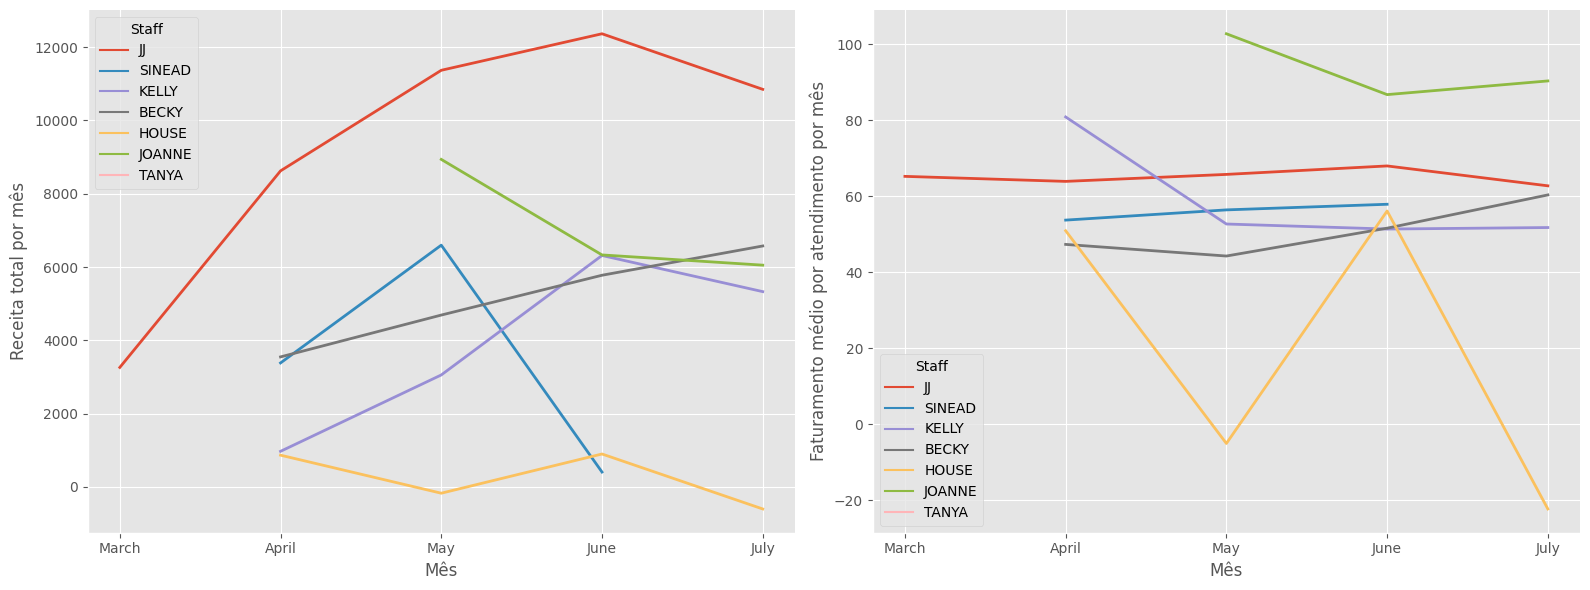

In [66]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

sns.lineplot(data = receita_mes, x='mes_nome' , y='sum', hue = 'Staff',linewidth=2, ax=ax[0])
sns.lineplot(data = receita_mes, x='mes_nome' , y='mean', hue = 'Staff',linewidth=2, ax=ax[1])

ax[0].set_xlabel("Mês",size=12)
ax[1].set_xlabel("Mês",size=12)
ax[0].set_ylabel("Receita total por mês",size=12)
ax[1].set_ylabel("Faturamento médio por atendimento por mês",size=12)

plt.tight_layout()

In [67]:
# Verificando até quando há dados no mês de Julho
transacoes.query('mes_nome == "July"')['Date'].max()

Timestamp('2018-07-29 00:00:00')

In [68]:
qt_trabalhadas = transacoes.groupby(['mes_nome','mes_n'])['Staff'].value_counts().to_frame().sort_values(by=['mes_n']).reset_index()
qt_trabalhadas.head()

,mes_nome,mes_n,Staff,count
0,March,3,JJ,50
1,April,4,JJ,135
2,April,4,BECKY,75
3,April,4,SINEAD,63
4,April,4,HOUSE,17


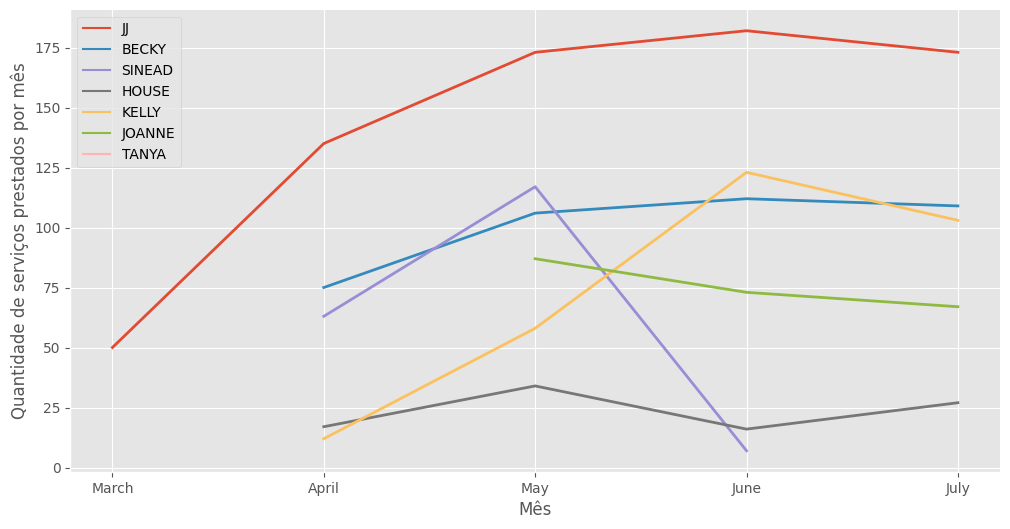

In [69]:
plt.figure(figsize=(12,6))
sns.lineplot(data = qt_trabalhadas,x='mes_nome' , y='count',hue='Staff',linewidth=2)

plt.ylabel("Quantidade de serviços prestados por mês",size=12)
plt.xlabel("Mês",size=12)
plt.legend(loc = "upper left");

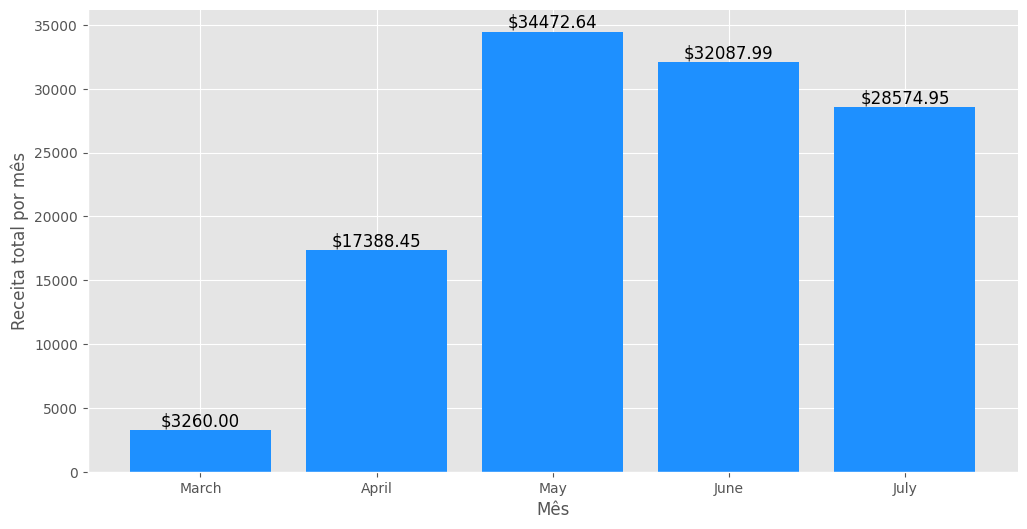

In [70]:
receita_total_por_mes = receita_mes.groupby(['mes_n','mes_nome'])['sum'].sum().to_frame().reset_index().sort_values(by='mes_n')
receita_total_por_mes = receita_total_por_mes.set_index('mes_nome')
receita_total_por_mes['mes_name'] = receita_total_por_mes.index

plt.figure(figsize=(12,6))
plt.bar(x=receita_total_por_mes['mes_name'], height=receita_total_por_mes['sum'],color='dodgerblue')

plt.ylabel("Receita total por mês",size=12)
plt.xlabel("Mês",size=12);

for mes in receita_total_por_mes.index.to_list():
    plt.text(mes,receita_total_por_mes.loc[mes,'sum'],f"${receita_total_por_mes.loc[mes,'sum']:.2f}",ha='center',va='bottom',fontsize=12)


 1. **Conclusões com relação a soma**
 
    >É notável o sucesso de JJ, observamos o seu faturamento aumentando mês após mês.
  
    >Percebemos que a Joanne tem o seu faturamento diminuindo mês após mês. Seu maior faturamento ocorreu justamente no mês em que entrou no salão.

    > Há algo de muito estranho com os dados do House, de acordo com eles há despesas em vez de receitas. Teríamos que analisar mais afundo para descobrir se realmente representam despesas ou se são erros.

    > Todos, exceto Becky, tiveram uma diminuição de suas receitas no mês de Julho. A última data de Julho armazenada em nossa base corresponde ao dia 29/07/2018, portanto, todos trabalharam pelo mês todo.

    > Algo aconteceu com Sinead, ele foi o único que não se encontra dados referente ao mês de Julho. Seria isso um erro ou realmente não trabalhou no salão esse mês? Por quais motivos ele não trabalhou? Ele saiu do salão? Além disso, a receita de Sinead em Maio foi equivalente a \$6596 e em Junho caiu para \$405 e isso representa uma queda realmente expressiva. 

2. **Conclusões com relação a média**

   > Observamos que JJ não alterou de maneira expressiva pelo seu serviço o que manteve o preço médio por atendimento constante (a grosso modo) durante os meses.

   >  Joanne cobrava, em média, por mais de &dollar;100,00 pelos seus serviços quando entrou no salão, no mês seguinte os serviços diminuíram para &dollar;86,71 e por fim subiu para &dollar;90,31. Seria essa diminuição uma reação devido a queda de clientes? 

   > Novamente, os dados de House estão estranhos e demanda uma investigação além da base de dados.

   > É interessante ver que em Julho o único faturamento que aumentou com relação a Junho foi o de Becky, provavelmente isso ocorreu pois ela aumentou os preços pelos serviços prestados.

   > Notamos algo estranho com Sinead com relação ao seu faturamento, entretanto, em média não houve uma mudança expressiva do quanto ele cobrava por serviço prestado.

3. **Conclusões com relação aos serviços prestados por mês**

   > As receitas de JJ caíram provavelmente devido a menor quantidade de serviços prestados em Julho.

   > Outros funcionários realizam muito mais atendimentos do que Joanne, entretanto, ela fatura mais pois cobra mais caro. Será que isso está relacionado aos serviços que ela presta?

   > A queda no número de serviços prestados pela Joanne são preocupantes, em  Maio ela atendeu 87 clientes e em Julho caiu para 67 clientes. Isso representa uma queda de 23% referente a Maio.

   > Em Julho a Kelly também prestou menos serviços. Logo há evidências que a sua receita aumentou devido ao aumento dos preços pelos seus serviços.

4. **Conclusões gerais**

   * É interessante notar como a perspectiva de análise muda as nossas conclusões. Anteriormente concluímos que Joanne futuramente seria a pessoa com o maior faturamento do salão pois o seu preço médio era o maior de todos. Entretanto essa conclusão fica altamente questionável ao observamos sua trajetória mensalmente, notamos que os seus antedimentos cai mês após mês assim como a sua receita.

   * House é outro exemplo, encontramos dados questionáveis ao investigarmos mais detalhadamente a sua trajetória. Portanto, é necessário investigarmos mais afundo se esses dados estão corretos.

   * Tínhamos concluído que houve uma inversão nos faturamentos de Sinead com o de Becky, entretanto, o motivo disso é devido a falta de dados do Sinead referente ao mês de Julho. A falta de dados pode representar um erro, pode representar algum outro problema do Sinead ou até mesmo a sua saída do salão.



* É notável que quanto mais analisamos mais perguntas nós levantamos. Observamos as diferenças das nossas conclusões ao analisarmos os casos global e  mensal. Será que as nossas conclusões mudariam se analisarmos semanalmente ou diariamente?

* Acredito que já alcançamos conclusões muito interessantes

Para finalizar vamos analisar mais duas coisas.

3. Existe algum dia na semana preferido pelos clientes?

4. Quais são os serviços que cada funcionário presta?

### 3 - Há algum dia preferencial?

In [71]:
dias = transacoes.groupby(['dia_n','dia_nome']).size().to_frame().reset_index().sort_values(by='dia_n')

dias = dias.set_index('dia_nome')
dias['dia_name'] = dias.index


dias

,dia_n,0,dia_name
dia_nome,,,
Monday,0,1,Monday
Tuesday,1,378,Tuesday
Wednesday,2,278,Wednesday
Thursday,3,399,Thursday
Friday,4,413,Friday
Saturday,5,414,Saturday
Sunday,6,50,Sunday


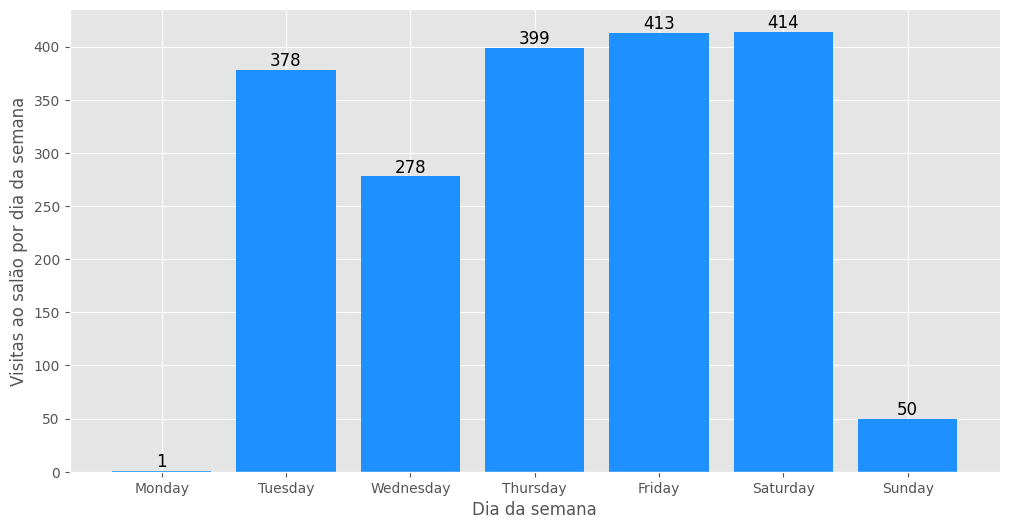

In [72]:
plt.figure(figsize=(12,6))
plt.bar(x=dias['dia_name'], height=dias[0],color='dodgerblue')

plt.ylabel("Visitas ao salão por dia da semana",size=12)
plt.xlabel("Dia da semana",size=12);

for dia in dias['dia_name']:
    plt.text(dia,dias.loc[dia,0],f"{dias.loc[dia,0]:.0f}",ha='center',va='bottom',fontsize=12)

**Conclusões**

> * Não há dias preferências.

> * Somente um serviço foi prestado na segunda feira durante 4 meses. Isso indica que os funcionários não devem trabalhar na segunda-feira.

> * Domingo é o dia menos movimentado, entretanto já esperávamos observar esse comportamento.

> * Quarta feira é o dia no meio da semana com menos clientes.

> * O Salão chegou ao seu máximo aos finais de semana (sexta e sábado).

Poderíamos cruzar os dados e determinar se há alguma diferença entre o dia da semana e os funcionários, entretanto, não faremos isso para não nos estendermos mais do que já estamos.

Vamos finalizar o entendimento sobre o salão voltando as nossa atenções para os serviços prestados pelos funcionários

In [73]:
servicos_prestados = transacoes.groupby('Description').size().to_frame(name='qte').sort_values(by='qte',ascending=False).reset_index()

print(f'Ao longo desses 4 meses o salão prestou {servicos_prestados["qte"].sum()} serviços')

servicos_prestados['(%)'] = servicos_prestados['qte']/1930*100
servicos_prestados.head(10)

Ao longo desses 4 meses o salão prestou 1930 serviços


,Description,qte,(%)
0,Women's hair cut,651,33.730570
1,Men's hair cut,374,19.378238
2,Blowdry,268,13.886010
3,Color touch up,83,4.300518
4,miscellaneous,57,2.953368
5,Consultation,47,2.435233
6,Color full color,45,2.331606
7,Highlights partial,36,1.865285
8,Accent lights and color,28,1.450777
9,Smart Bond,20,1.036269


In [74]:
top_20  = servicos_prestados.iloc[:20,:]
top_20 = top_20.set_index('Description')
top_20['Description'] = top_20.index

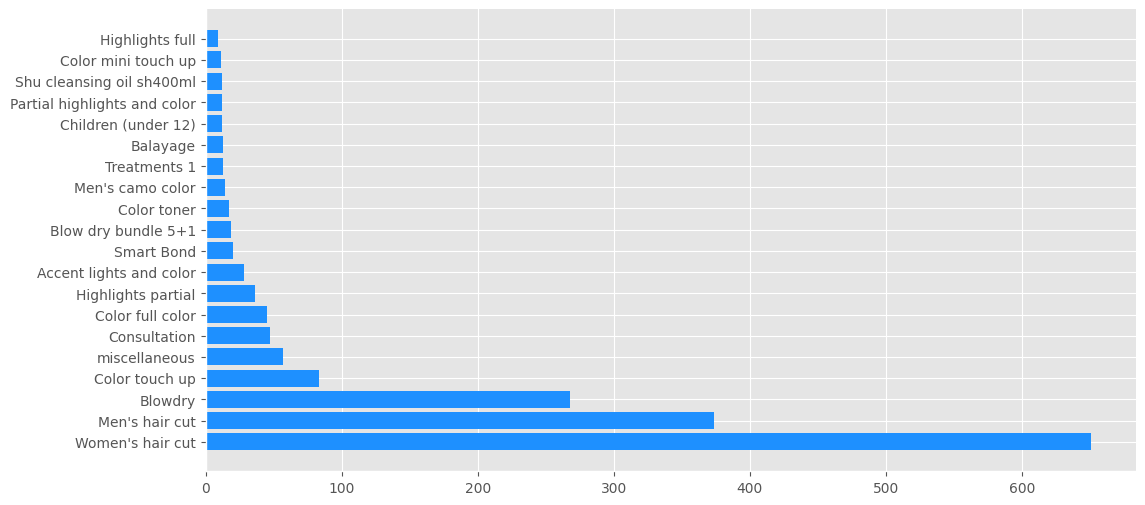

In [75]:
plt.figure(figsize=(12,6))
plt.barh(y=top_20['Description'],width=top_20['qte'],color='dodgerblue');

**Conclusões:**

> * Ao todo foram prestados 1930 serviços durante os 4 meses
>
> * Os serviços mais prestados foram:
>
>    * **Corte feminino:** 651 serviços e corresponde a 33,73% de todos os serviços
>
>    * **Corte masculino:** 374 serviços e corresponde a 19,38% de todos os serviços
>
>    * **Escova:** 268 serviços e corresponde a 13,89% de todos os serviços
>
>    * **Retoque:** 83 serviços e corresponde a 4,30% de todos os serviços
>
>    * **Demais serviços:** Equivalem a 554 serviços o que corresponde a 28,70%

 > * Apesar dos cortes feminino e masculino serem os mais populares e juntos somando 53,11% dos serviços prestados, observamos que os serviços que correspondem a menos de 4% quando somados representam 28,70% do total, totalizando 554 serviços. Esse fenômeno pode indicar uma grande diversificação na demanda por serviços de beleza, mostrando que os clientes procuram uma variedade de tratamentos e estilos além dos cortes tradicionais. Isso pode ser uma oportunidade para expandir o leque de serviços oferecidos e atender a uma gama mais ampla de preferências dos clientes, potencialmente aumentando a receita e a fidelização. Além disso, é importante acompanhar de perto o desempenho desses serviços menos populares e avaliar se eles podem ser promovidos ou adaptados para atrair mais clientes e impulsionar o crescimento do negócio.

Por fim, na tabela serviço abaixo contem as colunas "Price" e "Cost". De acordo com o criador do dataset a coluna "price" e "cost" representam, respectivamente, o preço médio cobrado pelos funcionários por um determinado serviço e a colaboração para o salão.

Notamos duas coisas:

> **1.** Muitos serviços na coluna "price" estão zerados, o que pode representar algum problema.
>
>
> **2.** O modelo de negócio do salão é diferente do que estamos acostumados. Ele nos dá a entender que os funcionários realizam seus serviços no salão e, em seguida, contribuem com uma parcela de suas receitas como aluguel. Isso funciona como se o dono do salão alugasse os espaços e seus equipamentos para cada serviço prestado.

O modelo de negócio baseado em aluguel de espaços pode ser vantajoso tanto para o dono do salão quanto para os funcionários, pois compartilha os custos e as receitas de forma eficiente.

In [76]:
servicos

,IsActive,Code,Desc,Cate,Price,Cost
0,True,CAL,accent lights,COLOR,0,10
1,True,CALC,Accent lights and color,COLOR,0,10
2,True,CAS,Color additional service,COLOR,0,10
3,True,CBAL,Balayage,COLOR,0,10
4,True,CCAMO,Men's camo color,COLOR,45,5
5,True,CCO,Color correction,COLOR,0,10
6,True,CDPB,double process blonde,COLOR,0,10
7,True,CFC,Color full color,COLOR,0,10
8,True,CHLFH,Highlights full,COLOR,0,10
9,True,CHLFHC,Full Highlights and color,COLOR,0,0


## **Clientes**

Agora vamos voltar a nossa atenção para o lado do cliente.

Vamos utilizar as seguintes tabelas:

> * Reservas futuras
> * Transações
> * Cancelados
> * Faltantes

Organizando os datasets

In [77]:
def define_turno(hora):
    if hora < 12:
        return "manha"
    elif hora <18:
        return "tarde"
    else:
        return "noite"

In [78]:
reservas_futuras['Date'] = pd.to_datetime(reservas_futuras['Date'])
reservas_futuras['Time'] = pd.to_datetime(reservas_futuras['Time'])
reservas_futuras['turno'] = reservas_futuras['Time'].apply(lambda x: define_turno(x.hour))
reservas_futuras = reservas_futuras.drop('Time',axis=1)

cancelados['Cancel Date'] = pd.to_datetime(cancelados['Cancel Date'])
cancelados['Booking Date'] = pd.to_datetime(cancelados['Booking Date'])
faltantes['Date'] = pd.to_datetime(faltantes['Date'])


Vamos identificar se há clientes cujo o código/nome está como valor ausente e remove-los.

In [79]:
transacoes['Client'].isna().sum() ,cancelados['Code'].isna().sum(), faltantes['Code'].isna().sum()

(0, 0, 1)

In [80]:
faltantes = faltantes.dropna()
transacoes['Client'].isna().sum() ,cancelados['Code'].isna().sum(), faltantes['Code'].isna().sum()

(0, 0, 0)

Notamos que foram realizadas 767 transações para o salão, 150 cancelamentos e 48 não comparecimentos sem cancelamento.

In [81]:
transacoes['Client'].nunique() ,cancelados['Code'].nunique(), faltantes['Code'].nunique()

(767, 150, 48)

Antes de realmente entendermos os clientes nós vamos responder a uma simples pergunta: 

Em média/mediana um cliente que cancelou faz isso quantos dias antes do serviço?

Notamos da tabela a seguir algumas estatísticas descritivas  da diferença de dias entre o dia que foi desmarcado e o dia do serviço. Notamos que existe valores negativos e esses valores representam algum erro. Vamos remover qualquer valor negativo

In [82]:
cancelados['Days'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
Days,239.0,5.230126,10.6858,-37.0,0.0,1.0,7.0,66.0


In [83]:
idx = cancelados.query('Days < 0').index
cancelados = cancelados.drop(idx)


Observamos que os clientes cancelam os serviços em média com 5 dias de antecedência, entretanto, notamos pelo histograma e pelas estatística abaixo que o mais indicado seria considerarmos a mediana.

Vamos salientas alguns pontos notados

> 1. Metade dos cancelamentos foram realizados até um dia antes da data prevista para o serviço.
>
> 2. 32,77% dos cancelamentos foram realizados a algumas horas antes do serviço.
>
> 3. 18% dos cancelamentos foram realizados a 1 dia antes do serviço.
>
> 4. 7% dos cancelamentos foram realizados a 1 semana antes do serviço.
>
> 5. 80% de todos os cancelamentos foram feitos pelo menos até 1 semana antes do serviço

In [84]:
cancelados['Days'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
Days,238.0,5.407563,10.349477,0.0,0.0,1.0,7.0,66.0


In [85]:
dias = cancelados.groupby('Days').size().to_frame('#').reset_index()
dias['%'] = (dias['#']/dias['#'].sum())*100
dias['%_acum'] = dias['%'].cumsum()
dias

,Days,#,%,%_acum
0,0.0,78,32.773109,32.773109
1,1.0,43,18.067227,50.840336
2,2.0,19,7.983193,58.823529
3,3.0,16,6.722689,65.546218
4,4.0,9,3.781513,69.327731
5,5.0,5,2.100840,71.428571
6,6.0,4,1.680672,73.109244
7,7.0,17,7.142857,80.252101
8,8.0,10,4.201681,84.453782
9,9.0,4,1.680672,86.134454


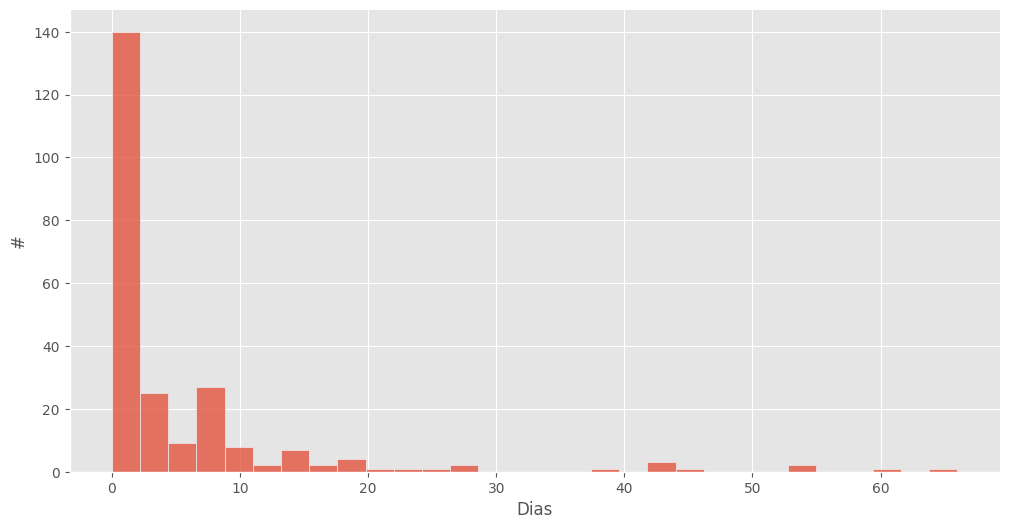

In [86]:
plt.figure(figsize=(12,6))
sns.histplot(data=cancelados,x='Days')
plt.ylabel('#')
plt.xlabel('Dias');

Vamos investigar melhor quem são os nossos clientes.

1. Calcular a Recencia
2. Calcular a frequência
3. Calcular a soma dos valores transferidos para o salão
4. Calcular a frequência que um mesmo cliente faltou e cancelou

Vamos criar um novo dataset para acumular todos os nossos processamentos

In [87]:
compilado = pd.DataFrame()
compilado['cliente'] = transacoes['Client'].unique()
compilado

,cliente
0,KERT01
1,COOM01
2,PEDM01
3,BAIS01
4,FRAL01
...,...
762,STOK02
763,NGC01
764,MERN01
765,CALC01


### Calculando o valor

Vamos começar por esse pois devemos nos lembrar que existem clientes com valores negativos.

Não há como sabermos o motivo disso, portanto, eu vou estar excluindo qualquer cliente com valores de "Amount" negativos.

In [88]:
print(f"Total de clientes Antes da remoção: {transacoes.shape[0]}")
idx = transacoes.query("Amount < 0").index
transacoes = transacoes.drop(idx)

print(f"Total de clientes após a remoção: {transacoes.shape[0]} || Clientes com valores menores de Amount menores que zero removidos: {idx.shape[0]}")

Total de clientes Antes da remoção: 1933
Total de clientes após a remoção: 1862 || Clientes com valores menores de Amount menores que zero removidos: 71


In [89]:
valor = transacoes.groupby('Client')['Amount'].agg(['mean']).reset_index()
valor = valor.rename({'Client':'cliente',
              'mean':'media_pago'},axis=1)

compilado = pd.merge(left=compilado,right=valor,on='cliente',how='left')
compilado.head()

,cliente,media_pago
0,KERT01,89.0
1,COOM01,75.0
2,PEDM01,30.0
3,BAIS01,55.0
4,FRAL01,70.0


### Calculando a recencia com base na data do dia 29/07/2018

In [90]:
data_referencia = transacoes['Date'].max()
data_referencia

Timestamp('2018-07-29 00:00:00')

In [91]:
recencia = (data_referencia - transacoes.groupby('Client')['Date'].max()).to_frame().reset_index()
recencia.columns=['cliente','recencia']
recencia['recencia'] = recencia['recencia'].dt.days

compilado = pd.merge(left=compilado,right=recencia,on='cliente',how='left')
compilado.head()

,cliente,media_pago,recencia
0,KERT01,89.0,39
1,COOM01,75.0,44
2,PEDM01,30.0,50
3,BAIS01,55.0,50
4,FRAL01,70.0,50


### Calculando a frequência

In [92]:
frequencia = transacoes.groupby('Client').size().to_frame(name='frequencia').reset_index().rename({'Client':'cliente'},axis=1)
compilado = pd.merge(left=compilado,right=frequencia,on='cliente',how='left')
compilado.head()

,cliente,media_pago,recencia,frequencia
0,KERT01,89.0,39,4
1,COOM01,75.0,44,2
2,PEDM01,30.0,50,2
3,BAIS01,55.0,50,1
4,FRAL01,70.0,50,2


### Calculando a frequência de vezes que um cliente faltou

In [93]:
faltou = faltantes.groupby('Code').size().to_frame(name='faltas').reset_index().rename({'Code':'cliente'},axis=1)

compilado = pd.merge(left=compilado,right=faltou,on='cliente',how='left')
compilado = compilado.fillna(0)
compilado.head()

,cliente,media_pago,recencia,frequencia,faltas
0,KERT01,89.0,39,4,0.0
1,COOM01,75.0,44,2,0.0
2,PEDM01,30.0,50,2,0.0
3,BAIS01,55.0,50,1,0.0
4,FRAL01,70.0,50,2,0.0


### Calculando a frequência que um cliente cancelou

In [94]:
cancelou = cancelados.groupby('Code').size().to_frame(name='cancelou').reset_index().rename({'Code':'cliente'},axis=1)
compilado = pd.merge(left=compilado,right=cancelou,on='cliente',how='left')
compilado = compilado.fillna(0)
compilado.head()

,cliente,media_pago,recencia,frequencia,faltas,cancelou
0,KERT01,89.0,39,4,0.0,0.0
1,COOM01,75.0,44,2,0.0,0.0
2,PEDM01,30.0,50,2,0.0,0.0
3,BAIS01,55.0,50,1,0.0,0.0
4,FRAL01,70.0,50,2,0.0,0.0


Agora vamos segmentar os clientes através de um algoritmo de clusterização

In [95]:
scaler = Normalizer()

comp_scaled = compilado.copy()

comp_scaled[['media_pago','recencia','frequencia','faltas','cancelou']]=  scaler.fit_transform(comp_scaled[['media_pago','recencia','frequencia','faltas','cancelou']])

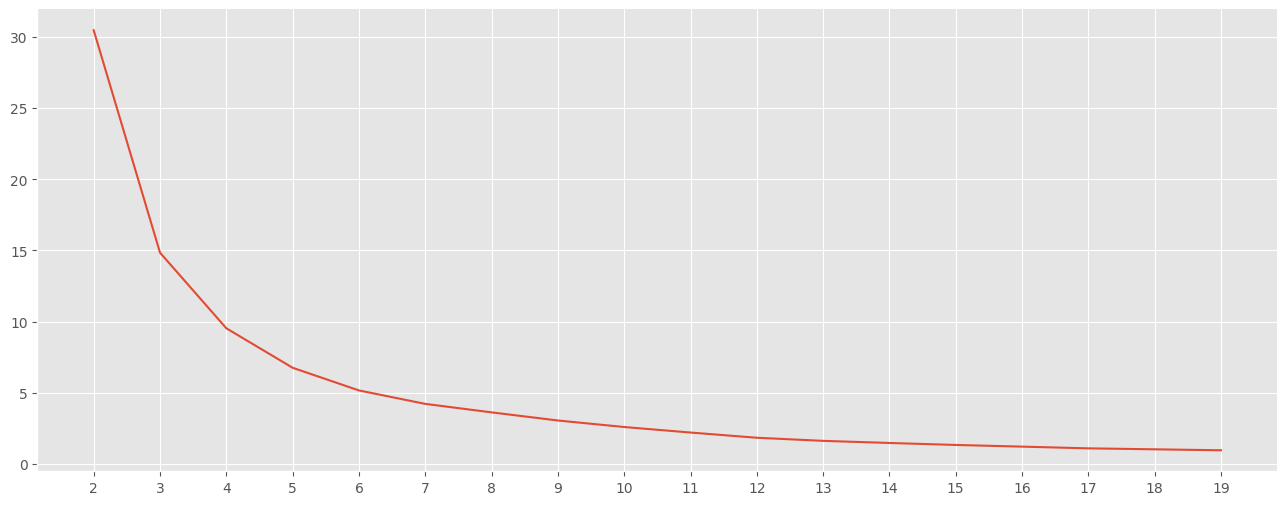

In [96]:
scores = {'n':[],'inertia':[]}
for n in range(2,20):
    kmeans = KMeans(n_clusters = n, random_state = 0)

    #kmeans.fit(comp_scaled[['media_pago','recencia','frequencia']])
    kmeans.fit(comp_scaled[['media_pago','recencia','frequencia']])

    scores['n'].append(n)
    scores['inertia'].append(kmeans.inertia_)

plt.plot(scores['n'],scores['inertia'])
plt.xticks(scores['n']);

Podemos inferir que o cotovelo está localizado em torno de 4 clusters.

In [97]:
kmeans = KMeans(n_clusters = 4, random_state = 0)
compilado['cluster'] = kmeans.fit_predict(comp_scaled[['media_pago','recencia','frequencia']])

Aqui eu gostaria de salientar que foram feitos vários testes para podermos selecionar um agrupamento que permitisse clusters mais homogêneos. Foram realizados testes com diferentes métodos de normalização/padronização, alteramos os modelos de clusterização entre Kmeans e Dbscan e até foi feita uma breve análise da quantidade de pessoas por cluster para n = 4 e n = 5. Por fim, chegamos em um resultado aparentemente bom, notamos que para n = 4 os clusters ficaram com uma quantidade razoável de pessoas por cluster. 

In [98]:
compilado.groupby('cluster').size()

cluster
0    229
1    103
2    244
3    191
dtype: int64

No gráfico a seguir podemos observar as relações entre os clusters e as características básicas dos clientes.

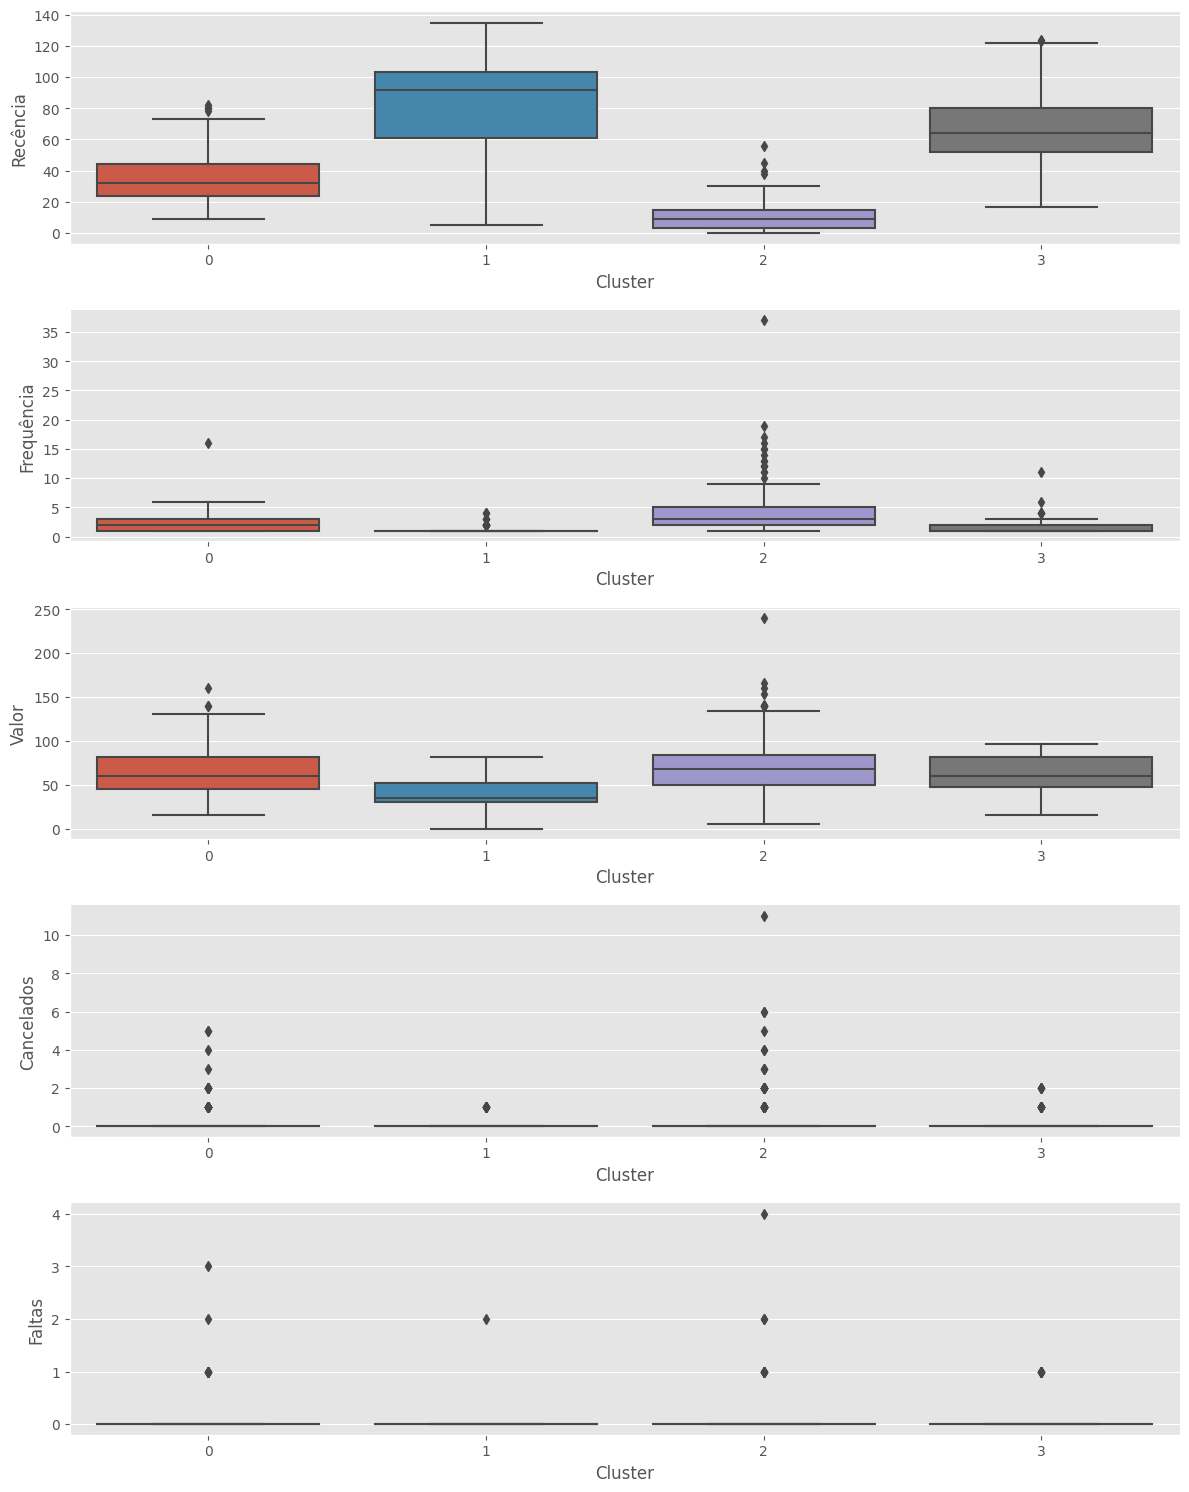

In [99]:
fig, ax = plt.subplots(5,1,figsize=(12,15))

sns.boxplot(data = compilado, y='recencia',x = 'cluster',ax=ax[0])
sns.boxplot(data = compilado, y='frequencia',x = 'cluster',ax=ax[1])
sns.boxplot(data = compilado, y='media_pago',x = 'cluster',ax=ax[2])
sns.boxplot(data = compilado, y='cancelou',x = 'cluster',ax=ax[3])
sns.boxplot(data = compilado, y='faltas',x = 'cluster',ax=ax[4])

ax[0].set_ylabel('Recência',size=12)
ax[1].set_ylabel('Frequência',size=12)
ax[2].set_ylabel('Valor',size=12)
ax[3].set_ylabel('Cancelados',size=12)
ax[4].set_ylabel('Faltas',size=12)

ax[0].set_xlabel('Cluster',size=12)
ax[1].set_xlabel('Cluster',size=12)
ax[2].set_xlabel('Cluster',size=12)
ax[3].set_xlabel('Cluster',size=12)
ax[4].set_xlabel('Cluster',size=12)

plt.tight_layout()

**Recência**

* O agrupamento 2 são os clientes mais recentes do salão. Em média esses clientes foram ao salão em +- 10 dias atrás dentro do intervalo de 4 meses adotado. 

* Por outro lado, o agrupamento 1 são os clientes menos recentes, onde em média, suas ultimas visitas foram em 85 dias atrás. 

* O grupo 3 tem em média 66 dias e o grupo 0 tem 34 dias.

**Frequência**

* O grupo 2 é configurado como o mais frequente, isto é, em 4 meses os clientes desse grupo foram ao salão  +- 3 vezes em média durante os 4 meses de referência

* O grupo 1 , por sua vez, é o de menor frequência, correspondendo apenas 1 visita em 4 meses.

* O grupo 3 tem 1 visita e o grupo 0 tem 2 visitas.

**Valor**

* O grupo 2 em média gasta /$70 por visita ao salão.

* O grupo 1 contribui com /$38 por visita.

* O grupo 0 e 3 são similares, onde o primeiro paga por serviço /$64 e o segundo por /$61

**Faltas e Cancelamentos:**

* Os algoritmos de clusterização não foram capazes de identificar a qual grupo pertencem as pessoas que cancelam ou faltam as reservas. Caso isso tivesse acontecido, nós teríamos uma maneira de identificar os possíveis faltantes/cancelas.


**Conclusão geral:**

* Notamos que o grupo 2 são aqueles clientes mais engajados no salão. São os clientes que foram mais recentemente, são os clientes que mais vão ao salão e por sua vez são os clientes que pagam mais pelos serviços, isso pode ser um indicativo que esses clientes recebem mais de um serviço por ida ao salão.

* Por outro lado, o grupo 1 são os clientes menos engajados, os que não retornaram ao salão depois de quase 3 meses e em média foram somente 1 vez. Podemos dizer que esses foram clientes esporádicos. Entretanto, nem todos os clientes desse cluster são esporádicos, portanto, um cliente comum deve receber uma atenção especial caso for incluído nesse grupo, isso pode ser um sinal de que a relação do cliente com o salão está esfriando.

* O grupo 3 são os clientes que foram ao salão  há 2 meses, são clientes que também foram pouco ao salão, sendo alguns desse grupo indo até 11 vezes dentro de 4 meses. Apesar de não serem clientes tão engajados, eles pagam em média /$61 pelos serviços. Diria que são clientes mornos ou até mesmo clientes com necessidades diferentes dos clientes do grupo 2, onde os serviços do salão não são considerados tão urgentes.

* Analisando o grupo 0 nós podemos notar características em comum com o grupo 3. Aparentemente são clientes que foram ao salão há um mês e de certo modo, são clientes que foram 2 vezes em 4 meses.Além disso, esse grupo se assemelha em termos de gastos com relação ao grupo 3, com o grupo 0 um pouco a mais. No meu entendimento são clientes também mornos ou com necessidades diferentes do grupo 2 e 3. 

* Notamos que a frequência de todos os grupos é um tanto quanto baixa, onde em média os clientes mais engajados foram 3 vezes em 4 meses e os menos engajados foram em torno de 1 a 2 vezes dentro do mesmo intervalo de referência. Alguma politica pode ser tomada para que a frequência de visitas aumente.

* Além dos serviços tradicionais que um salão presta, o dono do salão poderia adicionar outros tipos de serviços dentro do salão. Hoje em dia é muito comum ter geladeiras com produtos onde o cliente pode comprar o que quiser ali dentro, ou até mesmo em salões femininos tem sido muito comum a venda de roupas. Dessa forma o salão poderia aumentar o valor médio pago por cada cluster.


In [100]:
print('Recência:')
display(compilado.groupby('cluster')['recencia'].agg(['mean','std','median','max','min']).sort_values(by='mean',ascending=False))
print('Frequência:')
display(compilado.groupby('cluster')['frequencia'].agg(['mean','std','median','max','min']).sort_values(by='mean',ascending=False))
print('Valor:')
display(compilado.groupby('cluster')['media_pago'].agg(['mean','std','median','max','min']).sort_values(by='mean',ascending=False))

Recência:


,mean,std,median,max,min
cluster,,,,,
1,85.165049,28.135909,92.0,135,5
3,66.664921,21.758308,64.0,124,17
0,34.947598,15.061769,32.0,82,9
2,10.172131,8.466047,9.0,56,0


Frequência:


,mean,std,median,max,min
cluster,,,,,
2,3.790984,3.779052,3.0,37,1
0,2.331878,1.692057,2.0,16,1
3,1.439791,1.028687,1.0,11,1
1,1.242718,0.601730,1.0,4,1


Valor:


,mean,std,median,max,min
cluster,,,,,
2,70.190564,29.258883,67.492308,240.0,5.0
0,64.913253,24.516527,60.000000,160.0,15.0
3,61.215820,17.572301,60.000000,96.0,15.0
1,38.752427,19.624304,35.000000,82.0,0.0


Essa análise de segmentação de clientes nos abre margem para analisar uma centena de outras características. Como exemplo, poderíamos realizar um join da tabela de clientes segmentados com as demais tabelas e tentar encontrar outros padrões entre os clusters não vistos até o aqui. Levantamos a hipótese que o grupo 2 provavelmente recebe mais serviços por reserva, poderíamos verificar isso para estabelecer se realmente é isso o que ocorre ou não. Entretanto, acho que essa parte de análise está ficando um tanto quanto grande de mais e, portanto, preciso parar por aqui e dar continuidade no projeto e atacar outros problemas.

## **Cruzando tabelas:**


Até o momento nós aceitamos o fato de que as tabelas foram elaboradas corretamente, entretanto, neste tópico nós vamos investigar essa questão um pouco mais afundo.

Pense comigo, a tabela de transações, em tese, contém somente as transações pelos serviços já prestados. Logo, os clientes que estão ali na data que estão, foram ao salão receber o serviço. Desse modo, deveria ser impossível cruzar a tabela de cancelamentos ou faltantes, uma vez que essas pessoas não foram ao salão receber o serviço.

O mesmo raciocínio deve seguir para as tabelas cancelamentos e faltantes. Se o cliente faltou significa que ele não desmarcou, e deveria ser impossível cruzar essas duas tabelas.

Vamos cruzar essas tabelas entre si para determinar se houve erros na construção desses dados. Desse modo temos a chance de reduzir os ruídos dos dados que serão utilizados para treinar o nosso modelo de machine learning.